# Predicting 04/21/2020-04/30/2020 renewals by learning from the closed 04/01/2020-04/20/2020 renewals. 

This project aims to create a model to predict renewal likelihood to win each renewal opportunity. This project is a standard supervised classification task. It is supervised because the labels are included in the training data, and the goal is to train a model to learn to predict the labels from the features. It is a classification task because the label is a binary variable, 1 (will renewal opportunity), 0 (will not).
As it is obvious in this project, the real-world data is messy. So, data preparation, exploration, and feature engineering for finding the best model are essential. Selecting significant features and a proper model to get good results are required, too. According to our classification problem and our data structure, I tried to find a suitable model. Usually, we should try different models to get a good result. Finding correlations and plotting data are useful techniques that helped us to know our data and select an appropriate model.
In this project, two models are used. In combination with Grid Search, Logistic Regression and Random Forest are used to declare the best hyperparameters to avoid bias and overfitting. Also, K-fold cross-validation is a resampling method without replacement is used, which yields a lower-variance estimate of model performance.
This project's result shows that several factors have the most effects on the likelihood of renewal opportunities. The first one is the count of events for each account. The second one is the quantity of product, and the third factor is each account's contract duration.
This project's main steps are the following:

**Reading the data.**

I use the panda library to read data and work with it.

**Exploration and Preparation of the data**

In this section, calculating the statistics and making figures are helpful techniques to find trends, anomalies, patterns, or relationships within the data. For example, plotting the IS_WON variable in the train data shows an imbalanced class problem. So, tree ensembles like Random Forest is used.

Also, in this section, preprocessing steps such as changing some columns' data type like object to DateTime, encoding categorical variables, addressing missing values, and scaling features are performed to make the data ready for the next step.


**Modeling and Prediction**

In this section, the probability between 0 and 1 is predicted. Since the problem is a classification problem, Logistic Regression and Random Forest are used.
Also, the event_history file is divided into two parts contains train/test and prediction set. The first part, which contains IS_WON values, is divided into train and test sets. (04/01/2020-04/20/2020) The second part, which Is_Won values' is null, is divided into a prediction set. (04/21/2020-04/30/2020 )


**Improving the Model.**

At first, Logistic Regression and Grid Search are used to find the fine-tuning parameters. Grid Search can help to improve the performance of a model by finding the optimal combination of hyperparameter values.
Since the model's accuracy is about 83 percent on unseen data, another feature  (Event_count) from sample_event_history is added to the model. 

Also, Random Forest is an ensemble method, which has a better generalization performance. Additionally, the Random Forest seems to be better when the data is high-dimensional or too many outliers.
The average accuracy for using Cross-Validation of Random Forest is about to 86 percent, which is better than the previous model.

Cross-validation is used to evaluate the model's accuracy on different folds. Also, the F1 score, precision, recall, and confusion matrix are used to measure the models' relevance.

# Part one: Dependencies and Dataset

In [40]:
# modeling libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Libraries for evaluating models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix

# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# sklearn preprocessing for normaliing data
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [41]:
# Reading sample_event_history by panda and presenting it in a DataFrame
pd.set_option('display.max_colwidth',100)
df_event = pd.read_csv("sample_event_history.csv") 
df_event.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,ACCOUNT_ID,ORGANIZATION_ID,USER_ID,PROJECT_ID,EVENT_TIME,EVENT_TYPE,EVENT_COUNT
0,acc420,org1,u1,p1,2019-05-10,sheet.view,3
1,acc399,org2,u2,p2,2019-05-06,attachment.list.folder.filter,1
2,acc399,org2,u3,p3,2019-06-24,sheet.list.filter.select,2
3,acc122,org3,u4,p4,2019-04-30,sheet.list.filters.view,1
4,acc61,org4,u5,p5,2019-08-07,sheet.list,1


In [42]:
print('sample event history data shape: ', df_event.shape)
# The sample_event_history file contains 7226176 rows and 7 columns/features.

sample event history data shape:  (7226176, 7)


In [69]:
pd.set_option('display.max_colwidth',100)
df_opps = pd.read_csv("sample_opps.csv") 
df_opps.head(2)

,ACCOUNT_ID,OPPORTUNITY_ID,RENEWAL_DATE_C,PRODUCT_CODE,NAME,QUANTITY,START_DATE_C,END_DATE_C,IS_WON
0,acc1,opp1,2020-04-23,SS_550_AN_P2,PlanGrid (Nailgun - 550 Sheets),4,2020-04-24,2021-04-23,NaN
1,acc1,opp1,2020-04-23,SS_5K_AN_P2,PlanGrid (Dozer - 5000 Sheets),2,2020-04-24,2021-04-23,NaN


In [70]:
print('sample event history data shape: ', df_opps.shape)

sample event history data shape:  (1000, 9)


In [71]:
#The sample_opps table contains 1000 rows and 9 columns.

# Part two: Cleaning data and exploratory data analysis for preparing the data before classification

In [72]:
# Column Types
df_opps.dtypes.value_counts()

object    8
int64     1
dtype: int64

In [73]:
# IS_WON indicating 0 and 1 for renewal of contract between 04/01/2020-04/20/2020 
df_opps['IS_WON'].value_counts()

True     486
False     94
Name: IS_WON, dtype: int64

### Findig missing values

**We have to fix missing values problem before building a machine learning model. The columns with missing values are identified below.**

In [74]:
df_opps.isnull().any()
df_opps.info()
# the sample-opps files contains two rows with missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ACCOUNT_ID      1000 non-null   object
 1   OPPORTUNITY_ID  1000 non-null   object
 2   RENEWAL_DATE_C  1000 non-null   object
 3   PRODUCT_CODE    1000 non-null   object
 4   NAME            1000 non-null   object
 5   QUANTITY        1000 non-null   int64 
 6   START_DATE_C    998 non-null    object
 7   END_DATE_C      998 non-null    object
 8   IS_WON          580 non-null    object
dtypes: int64(1), object(8)
memory usage: 70.4+ KB


In [75]:
# This Function calculate missing values by columns
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [76]:
# looking for missing values statistics
missing_values = missing_values_table(df_opps)
missing_values.head(20)
# START_DATE_C and END_DATE_C columns contain two null values.
# IS_WON coulumn has 420 null values which will be filled by the result of prediction.

Your selected dataframe has 9 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
IS_WON,420,42.0
START_DATE_C,2,0.2
END_DATE_C,2,0.2


In [77]:
# For addresing missing values there are some solutions like filling them (imputation).
# Since the dataset just have two rows with null valuse, the two rows can be removed.
# Removing two rows with null values.
df_opps.dropna(subset=['START_DATE_C','END_DATE_C'],inplace=True)
df_opps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998 entries, 0 to 999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ACCOUNT_ID      998 non-null    object
 1   OPPORTUNITY_ID  998 non-null    object
 2   RENEWAL_DATE_C  998 non-null    object
 3   PRODUCT_CODE    998 non-null    object
 4   NAME            998 non-null    object
 5   QUANTITY        998 non-null    int64 
 6   START_DATE_C    998 non-null    object
 7   END_DATE_C      998 non-null    object
 8   IS_WON          579 non-null    object
dtypes: int64(1), object(8)
memory usage: 78.0+ KB


### Exploratory Data Analysis 
**In this section I calculate statistics and make figures to find trends, patterns, or relationships within the data. I want to learn what the data can tell us.**



<AxesSubplot:xlabel='IS_WON', ylabel='count'>

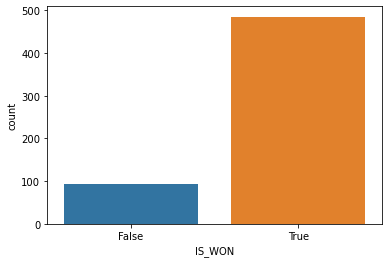

In [78]:
# Bar chart of renewal status count for data between 04/21/2020-04/30/2020 
sns.countplot(x='IS_WON', data=df_opps)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='QUANTITY'>

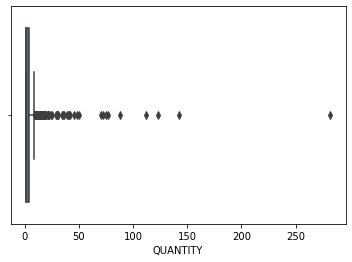

In [79]:
#Checking the distribution of the QUANTITY column
import seaborn as sns
sns.boxplot(df_opps['QUANTITY'])
# For prediction the QUANTITY column will be normalized because of the skewed distribution.

In [80]:
# Grouping by the product and calculate sum of quantity per product
products  = df_opps.groupby('NAME', sort=True).sum()
products

,QUANTITY
NAME,
Connect Platform,1
PlanGrid (Admin Console),97
PlanGrid (Advanced RFIs),15
PlanGrid (Automatic Submittal Log - Unlimited Users),1
PlanGrid (Automatic Submittal Log - Up to 200 Users),1
PlanGrid (Automatic Submittal Log - Up to 50 Users),4
PlanGrid (Automatic Submittal Log - Up to 500 Users),1
PlanGrid (Crane - Infinite Sheets),547
PlanGrid (Developer API Access),5


In [81]:
# Grouping by the product and calculate sum of quantity per product
products  = df_opps.groupby('PRODUCT_CODE', sort=True).sum()
products

,QUANTITY
PRODUCT_CODE,
API_DEV_AN,5
API_PGC1_AN,1
SS_550_AN_P2,1510
SS_5K_AN_P2,1915
SS_ASL1.1_AN,4
SS_ASL2.1_AN,1
SS_ASL3.1_AN,1
SS_ASL4.1_AN,1
SS_EC_T0,97


In [82]:
# NAME and PRODUCT_CODE are the same. I will use PRODUCT_CODE in prediction.

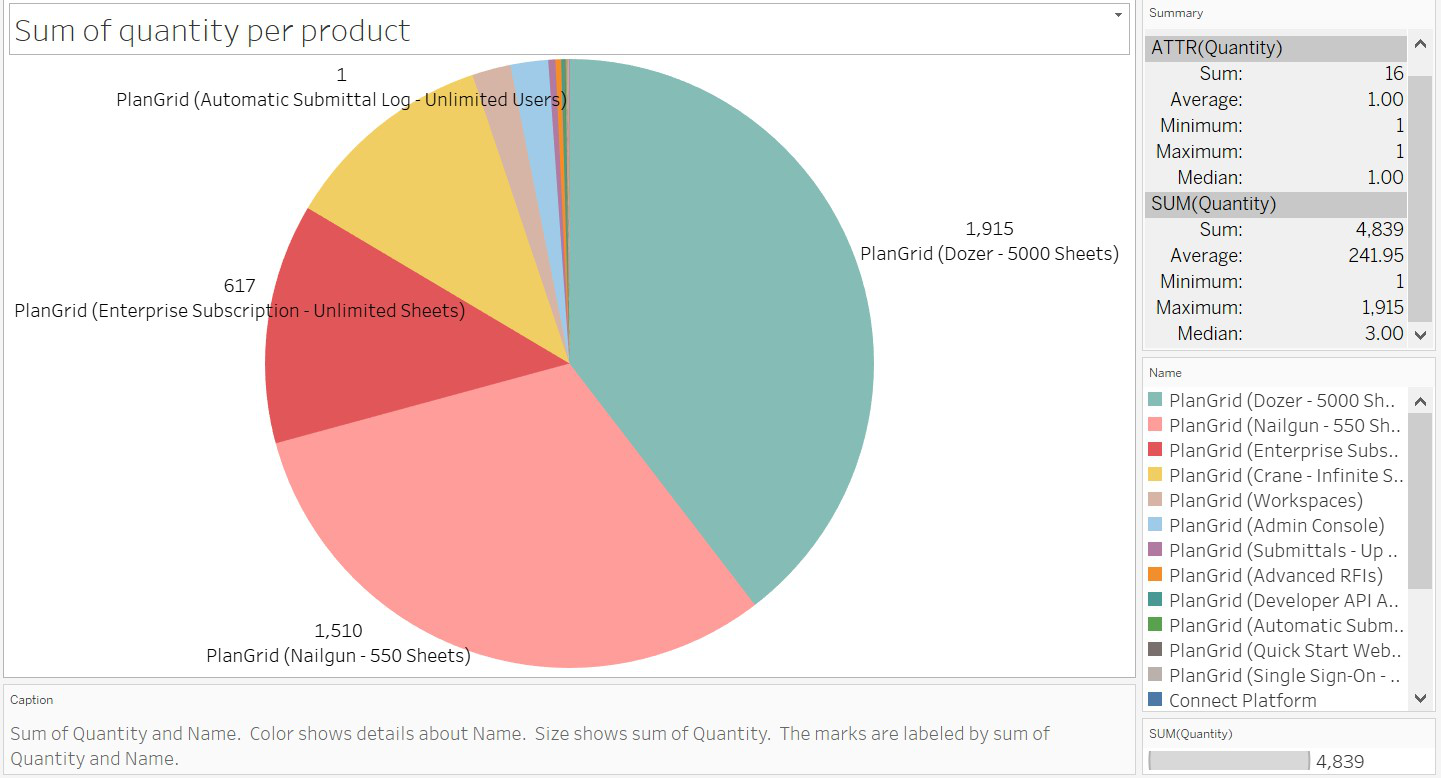

In [83]:
from PIL import Image
im = Image.open("Sum of quantity per product.jpg") 
im  
# This pie chart shows sum of quantities per product.

In [84]:
# Column types
# Number of each type of column 
df_opps.dtypes.value_counts()

object    8
int64     1
dtype: int64

In [85]:
df_opps.describe()

,QUANTITY
count,998.000000
mean,4.846693
std,13.514862
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,282.000000


In [86]:
# Converting date columnsto datetime because of two reasons:
#1) spliting data to train/test set for prediction
#2) Evaluating each contract's duration
cols = ['RENEWAL_DATE_C','START_DATE_C','END_DATE_C']
df_opps[cols] = df_opps[cols].apply(pd.to_datetime)

In [87]:
print(df_opps['START_DATE_C'].min())
print(df_opps['START_DATE_C'].max())
print(df_opps['END_DATE_C'].min())
print(df_opps['END_DATE_C'].max())

2019-10-01 00:00:00
2021-04-12 00:00:00
2020-07-31 00:00:00
2023-04-30 00:00:00


In [88]:
# Creating a new feature called contract duration to use in prediction
df_opps['CONTRACT_DURATION'] = df_opps['END_DATE_C'].sub(df_opps['START_DATE_C'], axis=0)

#checking max and min to see if there are any outliers
print(df_opps['CONTRACT_DURATION'].max())
print(df_opps['CONTRACT_DURATION'].min())


1094 days 00:00:00
126 days 00:00:00


In [89]:
# Changing contract's duration to number for using in the prediction model
df_opps['CONTRACT_DURATION'] = df_opps['CONTRACT_DURATION'].dt.days.astype(int)

In [90]:
print(df_opps['CONTRACT_DURATION'].max())
print(df_opps['CONTRACT_DURATION'].min())


1094
126


In [91]:
# Ordering columns for easier access for use in prediction models.
column_names = ['IS_WON','ACCOUNT_ID', 'OPPORTUNITY_ID', 'RENEWAL_DATE_C','START_DATE_C','END_DATE_C','NAME','PRODUCT_CODE',
       'QUANTITY', 'CONTRACT_DURATION']
df_opps = df_opps.reindex(columns=column_names)
df_opps.head(2)

,IS_WON,ACCOUNT_ID,OPPORTUNITY_ID,RENEWAL_DATE_C,START_DATE_C,END_DATE_C,NAME,PRODUCT_CODE,QUANTITY,CONTRACT_DURATION
0,NaN,acc1,opp1,2020-04-23,2020-04-24,2021-04-23,PlanGrid (Nailgun - 550 Sheets),SS_550_AN_P2,4,364
1,NaN,acc1,opp1,2020-04-23,2020-04-24,2021-04-23,PlanGrid (Dozer - 5000 Sheets),SS_5K_AN_P2,2,364


### Feature scaling
**Before classification, we should normalize the range of features which will be used in the model. (feature scaling).**


In [92]:
# CONTRACT_DURATION and QUANTITY will be used in classification. So, they are normalized.
sc_Q = StandardScaler()
sc_D = StandardScaler()
df_opps[['std_QUANTITY ']] = sc_Q.fit_transform(df_opps[['QUANTITY']])
df_opps[['std_CONTRACT_DURATION']] = sc_D.fit_transform(df_opps[['CONTRACT_DURATION']])


In [93]:
# Looking at the number of unique entries in each of the object (categorical) columns
df_opps.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

IS_WON              2
ACCOUNT_ID        527
OPPORTUNITY_ID    536
NAME               19
PRODUCT_CODE       19
dtype: int64

### One-hot encoding of categorical variables
**Since NAME and PRODUCT_CODE are the same, PRODUCT_CODE is encoded and will be used in the prediction.**


In [94]:
df_opps = pd.concat([df_opps, pd.get_dummies(df_opps['PRODUCT_CODE'], prefix='PRODUCT_CODE')], axis=1)
df_opps.head(2)

,IS_WON,ACCOUNT_ID,OPPORTUNITY_ID,RENEWAL_DATE_C,START_DATE_C,END_DATE_C,NAME,PRODUCT_CODE,QUANTITY,CONTRACT_DURATION,...,PRODUCT_CODE_SS_INF_AN_P2,PRODUCT_CODE_SS_INF_EN,PRODUCT_CODE_SS_RFI_AN,PRODUCT_CODE_SS_SSO1_AN,PRODUCT_CODE_SS_SSO2_AN,PRODUCT_CODE_SS_SUBM1_AN,PRODUCT_CODE_SS_SUBM2_AN,PRODUCT_CODE_SS_SUBM3.1_AN,PRODUCT_CODE_SS_SUBM3_AN,PRODUCT_CODE_SS_WORK_AN
0,NaN,acc1,opp1,2020-04-23,2020-04-24,2021-04-23,PlanGrid (Nailgun - 550 Sheets),SS_550_AN_P2,4,364,...,0,0,0,0,0,0,0,0,0,0
1,NaN,acc1,opp1,2020-04-23,2020-04-24,2021-04-23,PlanGrid (Dozer - 5000 Sheets),SS_5K_AN_P2,2,364,...,0,0,0,0,0,0,0,0,0,0


### Dividing to train/test set and prediction set
**Since the question is: 'Predict 04/21/2020-04/30/2020 renewals by learning from the closed 04/01/2020-04/20/2020 renewals,' the event_history file will be divided into two parts contains train/test and prediction set. The first part, which contains IS_WON values, will be divided to train and test sets. (04/01/2020-04/20/2020) The second part, which Is_Won values' is null, will be divided into a prediction set. (04/21/2020-04/30/2020 )**

In [95]:
# Spliting data to two part:
# 1) The first part contains train and test set.
# 2) The second part contains prediction set
split_date ='2020-04-20'
train = df_opps.loc[df_opps['RENEWAL_DATE_C'] <= split_date]
prediction = df_opps.loc[df_opps['RENEWAL_DATE_C'] > split_date]

In [96]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579 entries, 2 to 999
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   IS_WON                      579 non-null    object        
 1   ACCOUNT_ID                  579 non-null    object        
 2   OPPORTUNITY_ID              579 non-null    object        
 3   RENEWAL_DATE_C              579 non-null    datetime64[ns]
 4   START_DATE_C                579 non-null    datetime64[ns]
 5   END_DATE_C                  579 non-null    datetime64[ns]
 6   NAME                        579 non-null    object        
 7   PRODUCT_CODE                579 non-null    object        
 8   QUANTITY                    579 non-null    int64         
 9   CONTRACT_DURATION           579 non-null    int32         
 10  std_QUANTITY                579 non-null    float64       
 11  std_CONTRACT_DURATION       579 non-null    float64       

In [97]:
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', prediction.shape)

Training Features shape:  (579, 31)
Testing Features shape:  (419, 31)


In [98]:
train.head(2)

,IS_WON,ACCOUNT_ID,OPPORTUNITY_ID,RENEWAL_DATE_C,START_DATE_C,END_DATE_C,NAME,PRODUCT_CODE,QUANTITY,CONTRACT_DURATION,...,PRODUCT_CODE_SS_INF_AN_P2,PRODUCT_CODE_SS_INF_EN,PRODUCT_CODE_SS_RFI_AN,PRODUCT_CODE_SS_SSO1_AN,PRODUCT_CODE_SS_SSO2_AN,PRODUCT_CODE_SS_SUBM1_AN,PRODUCT_CODE_SS_SUBM2_AN,PRODUCT_CODE_SS_SUBM3.1_AN,PRODUCT_CODE_SS_SUBM3_AN,PRODUCT_CODE_SS_WORK_AN
2,True,acc2,opp2,2020-04-16,2020-04-17,2021-04-16,PlanGrid (Crane - Infinite Sheets),SS_INF_AN_P2,1,364,...,1,0,0,0,0,0,0,0,0,0
3,True,acc2,opp2,2020-04-16,2020-04-17,2021-04-16,PlanGrid (Dozer - 5000 Sheets),SS_5K_AN_P2,8,364,...,0,0,0,0,0,0,0,0,0,0


In [99]:
prediction.head(2)

,IS_WON,ACCOUNT_ID,OPPORTUNITY_ID,RENEWAL_DATE_C,START_DATE_C,END_DATE_C,NAME,PRODUCT_CODE,QUANTITY,CONTRACT_DURATION,...,PRODUCT_CODE_SS_INF_AN_P2,PRODUCT_CODE_SS_INF_EN,PRODUCT_CODE_SS_RFI_AN,PRODUCT_CODE_SS_SSO1_AN,PRODUCT_CODE_SS_SSO2_AN,PRODUCT_CODE_SS_SUBM1_AN,PRODUCT_CODE_SS_SUBM2_AN,PRODUCT_CODE_SS_SUBM3.1_AN,PRODUCT_CODE_SS_SUBM3_AN,PRODUCT_CODE_SS_WORK_AN
0,NaN,acc1,opp1,2020-04-23,2020-04-24,2021-04-23,PlanGrid (Nailgun - 550 Sheets),SS_550_AN_P2,4,364,...,0,0,0,0,0,0,0,0,0,0
1,NaN,acc1,opp1,2020-04-23,2020-04-24,2021-04-23,PlanGrid (Dozer - 5000 Sheets),SS_5K_AN_P2,2,364,...,0,0,0,0,0,0,0,0,0,0


In [100]:
train.columns

Index(['IS_WON', 'ACCOUNT_ID', 'OPPORTUNITY_ID', 'RENEWAL_DATE_C',
       'START_DATE_C', 'END_DATE_C', 'NAME', 'PRODUCT_CODE', 'QUANTITY',
       'CONTRACT_DURATION', 'std_QUANTITY ', 'std_CONTRACT_DURATION',
       'PRODUCT_CODE_API_DEV_AN', 'PRODUCT_CODE_API_PGC1_AN',
       'PRODUCT_CODE_SS_550_AN_P2', 'PRODUCT_CODE_SS_5K_AN_P2',
       'PRODUCT_CODE_SS_ASL1.1_AN', 'PRODUCT_CODE_SS_ASL2.1_AN',
       'PRODUCT_CODE_SS_ASL3.1_AN', 'PRODUCT_CODE_SS_ASL4.1_AN',
       'PRODUCT_CODE_SS_EC_T0', 'PRODUCT_CODE_SS_INF_AN_P2',
       'PRODUCT_CODE_SS_INF_EN', 'PRODUCT_CODE_SS_RFI_AN',
       'PRODUCT_CODE_SS_SSO1_AN', 'PRODUCT_CODE_SS_SSO2_AN',
       'PRODUCT_CODE_SS_SUBM1_AN', 'PRODUCT_CODE_SS_SUBM2_AN',
       'PRODUCT_CODE_SS_SUBM3.1_AN', 'PRODUCT_CODE_SS_SUBM3_AN',
       'PRODUCT_CODE_SS_WORK_AN'],
      dtype='object')

### Label Encoding
**For categorical variables like 'IS_WON' with 2 unique categories, label encoding should be used.
For any categorical variable with more than 2 unique categories, one-hot encoding is used.**

In [101]:
# After spliting data to train/test and prediction, the label encoder is used for IS_WON column in train/test sets
# Create a label encoder object for train/test set(IS_WON)
# using 0 and 1 rather True and False values for IS_WON
le = LabelEncoder()
train= train.dropna().copy()
train['IS_WON'] = le.fit_transform(train['IS_WON'])   
train['IS_WON'].head(5)

2    1
3    1
4    1
5    1
6    1
Name: IS_WON, dtype: int32

In [102]:
# Columns IS_WON, CONTRACT_DURATION, QUANTITY, PRODUCT_CODE are used in the prediction models.
# These rows divide first set of data(train) (04/01/2020 to 04/20/2020) to train and test set. 
from sklearn.model_selection import train_test_split
X_train= train.iloc[:, 10:].values
y_train = train.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=0.33, random_state=42)
X_prediction= prediction.iloc[:, 10:].values

In [104]:
#Checking the train set
df=pd.DataFrame(X_train)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.284770,-0.358426,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.284770,-0.358426,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.284770,-0.358426,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.233438,-0.358426,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.062680,-0.358426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [241]:
train.iloc[:, 11:]

,std_CONTRACT_DURATION,PRODUCT_CODE_API_DEV_AN,PRODUCT_CODE_API_PGC1_AN,PRODUCT_CODE_SS_550_AN_P2,PRODUCT_CODE_SS_5K_AN_P2,PRODUCT_CODE_SS_ASL1.1_AN,PRODUCT_CODE_SS_ASL2.1_AN,PRODUCT_CODE_SS_ASL3.1_AN,PRODUCT_CODE_SS_ASL4.1_AN,PRODUCT_CODE_SS_EC_T0,PRODUCT_CODE_SS_INF_AN_P2,PRODUCT_CODE_SS_INF_EN,PRODUCT_CODE_SS_RFI_AN,PRODUCT_CODE_SS_SSO1_AN,PRODUCT_CODE_SS_SSO2_AN,PRODUCT_CODE_SS_SUBM1_AN,PRODUCT_CODE_SS_SUBM2_AN,PRODUCT_CODE_SS_SUBM3.1_AN,PRODUCT_CODE_SS_SUBM3_AN,PRODUCT_CODE_SS_WORK_AN
2,-0.358426,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,-0.358426,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.358426,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,-0.358426,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,-0.358426,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.455967,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,1.455967,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
997,-0.358426,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,-0.358426,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [106]:
pd.isnull(X_train).sum() > 0

False

In [107]:
pd.isnull(y_train).sum() > 0

False

## Part three: Modeling and Prediction




 **1. Simple Logistic Regression**

In [108]:
# Train on the training data with logistic regression
log_reg = LogisticRegression(solver='liblinear', C=10.0, random_state=0)
log_reg.fit(X_train, y_train)
y_pred=log_reg.predict(X_test)

In [109]:
log_reg .classes_

array([0, 1])

In [110]:
log_reg .coef_

array([[ 1.13160518e+00,  2.15481052e+00,  5.91728732e-02,
         5.81517275e-02,  9.56078392e-02, -1.02422226e-01,
         1.40529289e+00,  5.81517275e-02,  5.81517275e-02,
         0.00000000e+00,  9.50823430e-01, -4.47238427e-02,
        -3.09147091e+00,  1.67395829e+00,  1.02722252e-03,
         5.81517275e-02,  3.86743624e-01,  5.81517275e-02,
         5.81517275e-02,  0.00000000e+00,  5.88954375e-01]])

In [111]:
# Make predictions
# In the test, the first column is the probability of the target being 0 and the second column is the probability of the target being 1 .
# Making sure to select the second column only.
y_pred = log_reg.predict(X_test)
log_reg_pred = log_reg.predict_proba(X_test)[:, 1]

In [112]:
# Looking at the performance of the model to measure  the model's relevance.
score_ = log_reg.score(X_test, y_pred)
report = classification_report(y_test, y_pred)
print(score_)
print(report)

1.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.84      0.99      0.91       161

    accuracy                           0.83       192
   macro avg       0.42      0.50      0.45       192
weighted avg       0.70      0.83      0.76       192



In [113]:
# Confision matrix to look at performance of the learning algorithm.
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[  0,  31],
       [  1, 160]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

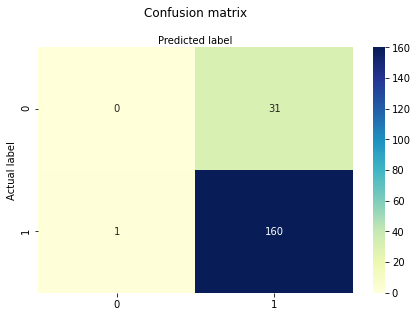

In [114]:
# Ploting Confision matrix 
%matplotlib inline
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [115]:
# Predicting the 04/21/2020-04/30/2020 renewals likelihood.
y_pred,log_reg_pred

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.79521762, 0.75631174, 0.80375887, 0.821158  , 0.99989332,
        0.89974478, 0.78123802, 0.91387837, 0.8939522 , 0.7455211 ,
        0.75631174, 0.79521762, 0.7455211 , 0.78123802, 0.7455211 ,
        0.7996136 , 0.7455211 , 0.7455211 , 0.77598329, 0.79521762,
        0.7455211 , 0.83313147, 0.84445516, 0.75631174, 0.8166371 ,
        0.

In [116]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train,y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)


Cross-Validation Accuracy Scores [0.84615385 0.84615385 0.82051282 0.84615385 0.84615385 0.84615385
 0.84615385 0.84210526 0.84210526 0.84210526]


In [117]:
# Evaliating the model
# We can then see the range of how our scores are
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

(0.8205128205128205, 0.8423751686909581, 0.8461538461538461)

#### 2. Imporoving the model via using grid search
**Tuning hyperparameters via grid search like regulariation parameters.**

In [118]:
# grid search for finding best parameters for the model
model = LogisticRegression()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8406882591093118
Best Hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [119]:
clf = search.best_estimator_
clf

LogisticRegression(C=10, penalty='l1', solver='liblinear')

In [120]:
# Fiting test set with the best parameters
clf.fit(X_train,y_train)
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.828


In [121]:
y_pred = clf.predict(X_prediction)
clf_pred = clf.predict_proba(X_prediction)[:, 1]

In [122]:
print(prediction.shape)
print(clf_pred.size)

(419, 31)
419


# Part four: Improving the model
**In this section, I will see if I can improve the predictions of the logistic regression model using an ensemble method, such as Random Forest, and adding a new feature to the model.**

### Adding new feature to the model to improve the previous model.
**The previous model's accuracy result with three features was around 83%. A new feature from the sample_event_history file will be added to the prediction model for improving the model. So, the sum of each EVENT_COUNT for each ACCOUNT_ID is calculated from sample_event_history and added to its ACCOUNT_ID in the sample_opps file. Also, ensemble models such as Random Forest, cross-validation will be used to make a better prediction.**

In [202]:
# Reading the sample_opps file, which EVENT_COUNT for each account is added to it. 
# The process of adding EVENT_COUNT has been done by SQL queries.
pd.set_option('display.max_colwidth',100)
df_opps = pd.read_csv("new_sample_opps.csv") 
df_opps.head(3)

,ACCOUNT_ID,OPPORTUNITY_ID,RENEWAL_DATE_C,PRODUCT_CODE,NAME,QUANTITY,START_DATE_C,END_DATE_C,IS_WON,EVENT_COUNT
0,acc1,opp1,4/23/2020,SS_550_AN_P2,PlanGrid (Nailgun - 550 Sheets),4,4/24/2020,4/23/2021,NaN,712.0
1,acc1,opp1,4/23/2020,SS_5K_AN_P2,PlanGrid (Dozer - 5000 Sheets),2,4/24/2020,4/23/2021,NaN,712.0
2,acc2,opp2,4/16/2020,SS_INF_AN_P2,PlanGrid (Crane - Infinite Sheets),1,4/17/2020,4/16/2021,True,129883.0


array([[<AxesSubplot:title={'center':'EVENT_COUNT'}>]], dtype=object)

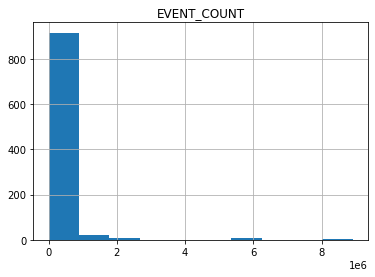

In [203]:
df_opps.hist(column='EVENT_COUNT')

In [204]:
# Event_count is skewed so we will log transform it
# Since using log gives better results than using Standard Scalar for normalization, log of EVENT_COUNT is used.
df_opps['log_EVENT_COUNT'] = pd.DataFrame(np.log(df_opps['EVENT_COUNT']))
df_opps['log_EVENT_COUNT']

0       6.568078
1       6.568078
2      11.774389
3      11.774389
4       8.238008
         ...    
995    13.131496
996    13.131496
997    13.536497
998    13.536497
999    13.536497
Name: log_EVENT_COUNT, Length: 1000, dtype: float64

array([[<AxesSubplot:title={'center':'log_EVENT_COUNT'}>]], dtype=object)

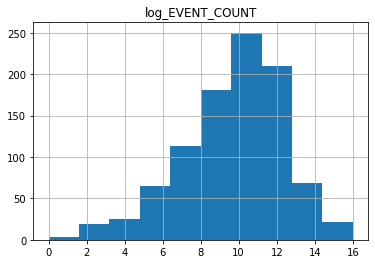

In [205]:
df_opps.hist(column='log_EVENT_COUNT')

In [206]:
df_opps.head(3)

,ACCOUNT_ID,OPPORTUNITY_ID,RENEWAL_DATE_C,PRODUCT_CODE,NAME,QUANTITY,START_DATE_C,END_DATE_C,IS_WON,EVENT_COUNT,log_EVENT_COUNT
0,acc1,opp1,4/23/2020,SS_550_AN_P2,PlanGrid (Nailgun - 550 Sheets),4,4/24/2020,4/23/2021,NaN,712.0,6.568078
1,acc1,opp1,4/23/2020,SS_5K_AN_P2,PlanGrid (Dozer - 5000 Sheets),2,4/24/2020,4/23/2021,NaN,712.0,6.568078
2,acc2,opp2,4/16/2020,SS_INF_AN_P2,PlanGrid (Crane - Infinite Sheets),1,4/17/2020,4/16/2021,True,129883.0,11.774389


**Data preparation like the previous model**

In [207]:
print('Sample opps data shape: ', df_opps.shape)

Sample opps data shape:  (1000, 11)


In [208]:
# This Function calculate missing values by columns
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [209]:
# looking for missing values statistics
missing_values = missing_values_table(df_opps)
missing_values.head(20)

Your selected dataframe has 11 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
IS_WON,420,42.0
EVENT_COUNT,44,4.4
log_EVENT_COUNT,44,4.4
START_DATE_C,2,0.2
END_DATE_C,2,0.2


**The sample_event_history file contains 496 unique ACCOUNT_ID.
The sample_opps contains 527 unique ACCOUNT_ID which 492 of them are in sample_event_history.
So, when Sum of EVENT_COUNT for each account is added to sample_opps, just 492 ACCOUNT_ID is updated with the Sum of EVENT_COUNT.
Since the number of rows that do not have EVENT_COUNT is 44, they could be removed or filled with data.**

In [210]:
# For addressing missing values, there are some solutions like filling in them (imputation).
# Since the dataset just has two rows with null values; they can be removed.
# Removing two rows with null values.('START_DATE_C','END_DATE_C')
# Removing 44 rows with null values.('EVENT_COUNT')
df_opps.dropna(subset=['START_DATE_C','END_DATE_C','EVENT_COUNT'],inplace=True)
df_opps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954 entries, 0 to 999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ACCOUNT_ID       954 non-null    object 
 1   OPPORTUNITY_ID   954 non-null    object 
 2   RENEWAL_DATE_C   954 non-null    object 
 3   PRODUCT_CODE     954 non-null    object 
 4   NAME             954 non-null    object 
 5   QUANTITY         954 non-null    int64  
 6   START_DATE_C     954 non-null    object 
 7   END_DATE_C       954 non-null    object 
 8   IS_WON           552 non-null    object 
 9   EVENT_COUNT      954 non-null    float64
 10  log_EVENT_COUNT  954 non-null    float64
dtypes: float64(2), int64(1), object(8)
memory usage: 89.4+ KB


In [211]:
# Converting date columns to DateTime because of two reasons:
#1) splitting data to train/test set for prediction
#2) Evaluating each contract's duration
cols = ['RENEWAL_DATE_C','START_DATE_C','END_DATE_C']
df_opps[cols] = df_opps[cols].apply(pd.to_datetime)

In [212]:
# Using contract durations as a feature in the training set
df_opps['CONTRACT_DURATION'] = df_opps['END_DATE_C'].sub(df_opps['START_DATE_C'], axis=0)
print(df_opps['CONTRACT_DURATION'].max())
print(df_opps['CONTRACT_DURATION'].min())

1094 days 00:00:00
126 days 00:00:00


In [213]:
# Changing contract's duration to number for using in the prediction model
df_opps['CONTRACT_DURATION'] = df_opps['CONTRACT_DURATION'].dt.days.astype(int)

In [214]:
# Ordering columns
column_names = ['IS_WON','ACCOUNT_ID', 'OPPORTUNITY_ID','EVENT_COUNT', 'RENEWAL_DATE_C','START_DATE_C','END_DATE_C','NAME','PRODUCT_CODE',
       'QUANTITY', 'CONTRACT_DURATION','log_EVENT_COUNT']
df_opps = df_opps.reindex(columns=column_names)
df_opps.head(3)

,IS_WON,ACCOUNT_ID,OPPORTUNITY_ID,EVENT_COUNT,RENEWAL_DATE_C,START_DATE_C,END_DATE_C,NAME,PRODUCT_CODE,QUANTITY,CONTRACT_DURATION,log_EVENT_COUNT
0,NaN,acc1,opp1,712.0,2020-04-23,2020-04-24,2021-04-23,PlanGrid (Nailgun - 550 Sheets),SS_550_AN_P2,4,364,6.568078
1,NaN,acc1,opp1,712.0,2020-04-23,2020-04-24,2021-04-23,PlanGrid (Dozer - 5000 Sheets),SS_5K_AN_P2,2,364,6.568078
2,True,acc2,opp2,129883.0,2020-04-16,2020-04-17,2021-04-16,PlanGrid (Crane - Infinite Sheets),SS_INF_AN_P2,1,364,11.774389


In [215]:
train_features = df_opps.drop(columns = ['IS_WON'])
features = list(train_features.columns)
print(features)

['ACCOUNT_ID', 'OPPORTUNITY_ID', 'EVENT_COUNT', 'RENEWAL_DATE_C', 'START_DATE_C', 'END_DATE_C', 'NAME', 'PRODUCT_CODE', 'QUANTITY', 'CONTRACT_DURATION', 'log_EVENT_COUNT']


In [216]:
df_opps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   IS_WON             552 non-null    object        
 1   ACCOUNT_ID         954 non-null    object        
 2   OPPORTUNITY_ID     954 non-null    object        
 3   EVENT_COUNT        954 non-null    float64       
 4   RENEWAL_DATE_C     954 non-null    datetime64[ns]
 5   START_DATE_C       954 non-null    datetime64[ns]
 6   END_DATE_C         954 non-null    datetime64[ns]
 7   NAME               954 non-null    object        
 8   PRODUCT_CODE       954 non-null    object        
 9   QUANTITY           954 non-null    int64         
 10  CONTRACT_DURATION  954 non-null    int32         
 11  log_EVENT_COUNT    954 non-null    float64       
dtypes: datetime64[ns](3), float64(2), int32(1), int64(1), object(5)
memory usage: 93.2+ KB


### **Feature scaling**

In [217]:
# CONTRACT_DURATION and QUANTITY will be used in classification. So, they are normalized.
sc_Q = StandardScaler()
sc_D = StandardScaler()
sc_E = StandardScaler()
df_opps[['std_QUANTITY ']] = sc_Q.fit_transform(df_opps[['QUANTITY']])
df_opps[['std_CONTRACT_DURATION']] = sc_D.fit_transform(df_opps[['CONTRACT_DURATION']])
# df_opps[['EVENT_COUNT']] = sc_E.fit_transform(df_opps[['EVENT_COUNT']])
# Since using log gives better results than using Standard Scalar for normalization, log of EVENT_CPOUNT is used.


In [218]:
# Looking at the number of unique entries in each of the object (categorical) columns
df_opps.select_dtypes('object').apply(pd.Series.nunique, axis = 0)
# Most of the categorical variables have a relatively small number of unique entries.

IS_WON              2
ACCOUNT_ID        492
OPPORTUNITY_ID    501
NAME               19
PRODUCT_CODE       19
dtype: int64

### One-Hot Encoding

In [219]:
df_opps = pd.concat([df_opps, pd.get_dummies(df_opps['PRODUCT_CODE'], prefix='PRODUCT_CODE')], axis=1)
df_opps.head(2)

,IS_WON,ACCOUNT_ID,OPPORTUNITY_ID,EVENT_COUNT,RENEWAL_DATE_C,START_DATE_C,END_DATE_C,NAME,PRODUCT_CODE,QUANTITY,...,PRODUCT_CODE_SS_INF_AN_P2,PRODUCT_CODE_SS_INF_EN,PRODUCT_CODE_SS_RFI_AN,PRODUCT_CODE_SS_SSO1_AN,PRODUCT_CODE_SS_SSO2_AN,PRODUCT_CODE_SS_SUBM1_AN,PRODUCT_CODE_SS_SUBM2_AN,PRODUCT_CODE_SS_SUBM3.1_AN,PRODUCT_CODE_SS_SUBM3_AN,PRODUCT_CODE_SS_WORK_AN
0,NaN,acc1,opp1,712.0,2020-04-23,2020-04-24,2021-04-23,PlanGrid (Nailgun - 550 Sheets),SS_550_AN_P2,4,...,0,0,0,0,0,0,0,0,0,0
1,NaN,acc1,opp1,712.0,2020-04-23,2020-04-24,2021-04-23,PlanGrid (Dozer - 5000 Sheets),SS_5K_AN_P2,2,...,0,0,0,0,0,0,0,0,0,0


In [220]:
split_date ='2020-04-20'
train = df_opps.loc[df_opps['RENEWAL_DATE_C'] <= split_date]
prediction = df_opps.loc[df_opps['RENEWAL_DATE_C'] > split_date]

In [221]:
print('Training Features shape: ', train.shape)
print('Prediction Features shape: ', prediction.shape)

Training Features shape:  (552, 33)
Prediction Features shape:  (402, 33)


### Label Encoding 

In [222]:
# Create a label encoder object for train/test set(IS_WON)
# using 0 and 1 rather than True and False values for IS_WON
le = LabelEncoder()
train= train.dropna().copy()
train['IS_WON'] = le.fit_transform(train['IS_WON'])   
train['IS_WON'].head(3)

2    1
3    1
4    1
Name: IS_WON, dtype: int32

In [223]:
from sklearn.model_selection import train_test_split
X_train= train.iloc[:, 11:].values
y_train = train.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=0.33, random_state=42)
X_prediction= prediction.iloc[:, 11:].values

In [224]:
train.iloc[:, 11:]

,log_EVENT_COUNT,std_QUANTITY,std_CONTRACT_DURATION,PRODUCT_CODE_API_DEV_AN,PRODUCT_CODE_API_PGC1_AN,PRODUCT_CODE_SS_550_AN_P2,PRODUCT_CODE_SS_5K_AN_P2,PRODUCT_CODE_SS_ASL1.1_AN,PRODUCT_CODE_SS_ASL2.1_AN,PRODUCT_CODE_SS_ASL3.1_AN,...,PRODUCT_CODE_SS_INF_AN_P2,PRODUCT_CODE_SS_INF_EN,PRODUCT_CODE_SS_RFI_AN,PRODUCT_CODE_SS_SSO1_AN,PRODUCT_CODE_SS_SSO2_AN,PRODUCT_CODE_SS_SUBM1_AN,PRODUCT_CODE_SS_SUBM2_AN,PRODUCT_CODE_SS_SUBM3.1_AN,PRODUCT_CODE_SS_SUBM3_AN,PRODUCT_CODE_SS_WORK_AN
2,11.774389,-0.284110,-0.364094,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,11.774389,0.228393,-0.364094,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.238008,-0.137680,-0.364094,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,8.238008,-0.284110,-0.364094,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,10.566304,-0.064466,-0.364094,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,13.131496,0.960539,1.434219,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,13.131496,0.521251,1.434219,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
997,13.536497,0.081964,-0.364094,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,13.536497,-0.284110,-0.364094,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [225]:
# Use the random grid to search for the best hyperparameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 4, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.7min finished


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=0, verbose=2)

In [255]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}

In [256]:
rf_r = rf_random.best_estimator_
rf_r

RandomForestClassifier(max_depth=70, min_samples_split=10, n_estimators=600)

In [257]:
# Fiting with the best parameters
rf_r.fit(X_train, y_train)
y_pred=rf_r.predict(X_test)
print('Test Accuracy: %.3f' % rf_r.score(X_test, y_test))

Test Accuracy: 0.863


In [258]:
y_pred = rf_r.predict_proba(X_prediction)[:,1]

In [260]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, pred)
cnf_matrix

array([[  7,  23],
       [  2, 151]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

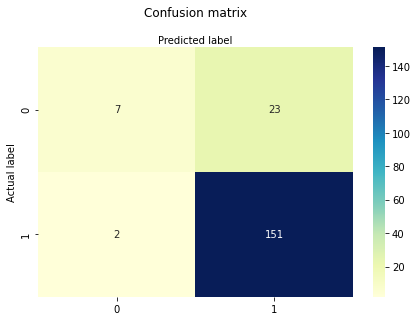

In [261]:
# Ploting Confision matrix 
%matplotlib inline
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [262]:
y_pred 

array([0.87449783, 0.85543076, 0.93476451, 0.99239815, 0.84851254,
       0.93874536, 0.84604561, 0.9997619 , 0.97819028, 0.98893075,
       0.87803102, 0.97901509, 0.93637892, 0.82646744, 0.96869241,
       0.908137  , 0.97304584, 0.96638389, 0.84999514, 0.9631968 ,
       0.99895588, 0.31230596, 0.99801874, 0.64478529, 0.95434252,
       0.71333462, 0.9661936 , 0.99928922, 0.7191641 , 0.84588647,
       0.68177835, 0.72892951, 0.99045339, 0.95851256, 0.29882749,
       0.74762575, 0.968775  , 0.94889425, 0.98034803, 0.99306509,
       0.89792109, 0.54270495, 0.99450307, 0.99009237, 0.98818759,
       0.96991876, 0.98697654, 0.7498735 , 0.63030805, 0.98227924,
       0.97380297, 0.8363677 , 0.91568115, 0.54043203, 0.93356624,
       0.76310038, 0.7156641 , 0.95656586, 0.64478529, 0.92029581,
       0.99140732, 0.88843069, 0.98832478, 0.992371  , 0.99611083,
       0.86297896, 0.83496021, 0.9726287 , 0.72052879, 0.96596306,
       0.96513536, 0.98430078, 0.85964563, 0.92121667, 0.22154

In [263]:
score_ = rf_r.score(X_test, pred)
report = classification_report(y_test, pred)
print(score_)
print(report)

1.0
              precision    recall  f1-score   support

           0       0.78      0.23      0.36        30
           1       0.87      0.99      0.92       153

    accuracy                           0.86       183
   macro avg       0.82      0.61      0.64       183
weighted avg       0.85      0.86      0.83       183



In [264]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_r, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.83783784 0.89189189 0.86486486 0.91891892 0.89189189 0.86486486
 0.94594595 0.83783784 0.83783784 0.91666667]


In [265]:
# We can then see the range of how our scores are doing
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

(0.8378378378378378, 0.8808558558558557, 0.9459459459459459)

In [266]:
df_test = pd.DataFrame(prediction)
df_test['win_probability'] =  y_pred 
df_test.head(3)

,IS_WON,ACCOUNT_ID,OPPORTUNITY_ID,EVENT_COUNT,RENEWAL_DATE_C,START_DATE_C,END_DATE_C,NAME,PRODUCT_CODE,QUANTITY,...,PRODUCT_CODE_SS_INF_EN,PRODUCT_CODE_SS_RFI_AN,PRODUCT_CODE_SS_SSO1_AN,PRODUCT_CODE_SS_SSO2_AN,PRODUCT_CODE_SS_SUBM1_AN,PRODUCT_CODE_SS_SUBM2_AN,PRODUCT_CODE_SS_SUBM3.1_AN,PRODUCT_CODE_SS_SUBM3_AN,PRODUCT_CODE_SS_WORK_AN,win_probability
0,NaN,acc1,opp1,712.0,2020-04-23,2020-04-24,2021-04-23,PlanGrid (Nailgun - 550 Sheets),SS_550_AN_P2,4,...,0,0,0,0,0,0,0,0,0,0.874498
1,NaN,acc1,opp1,712.0,2020-04-23,2020-04-24,2021-04-23,PlanGrid (Dozer - 5000 Sheets),SS_5K_AN_P2,2,...,0,0,0,0,0,0,0,0,0,0.855431
20,NaN,acc9,opp9,88350.0,2020-04-25,2020-04-26,2021-04-25,PlanGrid (Nailgun - 550 Sheets),SS_550_AN_P2,19,...,0,0,0,0,0,0,0,0,0,0.934765


In [267]:
header = ['OPPORTUNITY_ID','RENEWAL_DATE_C','win_probability']
df_test.to_csv('Jebeli_prediction.csv', columns = header, index=False)

In [268]:
# Checking the submission
submit_file = pd.read_csv('Jebeli_prediction.csv')
print('Testing data shape: ', submit_file.shape)
submit_file.head(10)

Testing data shape:  (402, 3)


,OPPORTUNITY_ID,RENEWAL_DATE_C,win_probability
0,opp1,2020-04-23,0.874498
1,opp1,2020-04-23,0.855431
2,opp9,2020-04-25,0.934765
3,opp9,2020-04-25,0.992398
4,opp9,2020-04-25,0.848513
5,opp10,2020-04-23,0.938745
6,opp10,2020-04-23,0.846046
7,opp13,2020-04-30,0.999762
8,opp13,2020-04-30,0.978190
9,opp13,2020-04-30,0.988931


# Model Interpretation
## Feature Importances

**A simple method to see which variables are the most relevant, is looking at the feature importances of our model.**

**Feature importances plot let us to understand what factors our model takes into account when it makes predictions.**

In [269]:
import pandas as pd
columns_ =train.iloc[:, 11:].columns
feature_importances = pd.DataFrame(rf_r.feature_importances_,
                                   index = columns_,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
log_EVENT_COUNT,0.640459
std_QUANTITY,0.154371
std_CONTRACT_DURATION,0.063689
PRODUCT_CODE_SS_5K_AN_P2,0.037983
PRODUCT_CODE_SS_INF_EN,0.025467
PRODUCT_CODE_API_DEV_AN,0.020542
PRODUCT_CODE_SS_550_AN_P2,0.016531
PRODUCT_CODE_SS_EC_T0,0.015036
PRODUCT_CODE_SS_INF_AN_P2,0.012050
PRODUCT_CODE_SS_WORK_AN,0.008436


In [270]:
train_features = df_opps.drop(columns = ['IS_WON'])
features = list(train.iloc[:, 11:].columns)
print(features)

['log_EVENT_COUNT', 'std_QUANTITY ', 'std_CONTRACT_DURATION', 'PRODUCT_CODE_API_DEV_AN', 'PRODUCT_CODE_API_PGC1_AN', 'PRODUCT_CODE_SS_550_AN_P2', 'PRODUCT_CODE_SS_5K_AN_P2', 'PRODUCT_CODE_SS_ASL1.1_AN', 'PRODUCT_CODE_SS_ASL2.1_AN', 'PRODUCT_CODE_SS_ASL3.1_AN', 'PRODUCT_CODE_SS_ASL4.1_AN', 'PRODUCT_CODE_SS_EC_T0', 'PRODUCT_CODE_SS_INF_AN_P2', 'PRODUCT_CODE_SS_INF_EN', 'PRODUCT_CODE_SS_RFI_AN', 'PRODUCT_CODE_SS_SSO1_AN', 'PRODUCT_CODE_SS_SSO2_AN', 'PRODUCT_CODE_SS_SUBM1_AN', 'PRODUCT_CODE_SS_SUBM2_AN', 'PRODUCT_CODE_SS_SUBM3.1_AN', 'PRODUCT_CODE_SS_SUBM3_AN', 'PRODUCT_CODE_SS_WORK_AN']


In [271]:
# Train on the training data
rf_r.fit(X_train, y_train)
# Extract feature importances
feature_importance_values =rf_r.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})
# Make predictions on the test data
predictions = rf_r.predict_proba(X_test)[:, 1]
y_train_pred_random = rf_r.predict(X_train)

In [272]:
# Plot importances returned by a model. This can work with any measure of feature importance provided that higher importance is better. 
# Returns: shows a plot of the 22 most importance features df (dataframe): feature importances sorted by importance (highest to lowest) with a column for normalized importance
def plot_feature_importances(df):
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

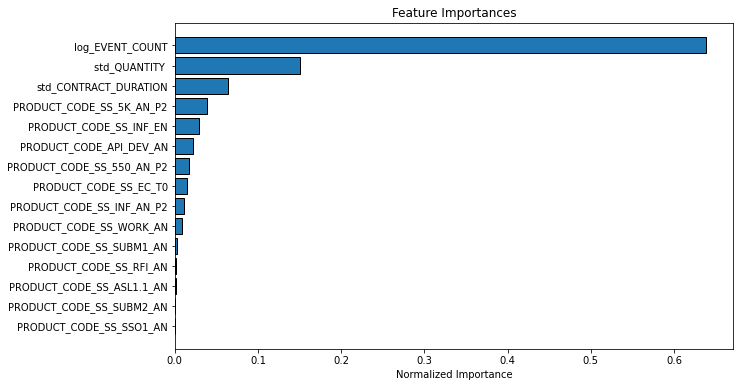

In [273]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)